In [1]:
import glob
import cv2
import math 
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import json
import datetime
import matplotlib.image as mpimg
import random
import time
import copy


%matplotlib inline
import pandas as pd
import numpy as np
np.random.bit_generator = np.random._bit_generator

from tensorflow.keras.preprocessing import image
from tensorflow import keras
from tensorflow.keras.layers import Input, Dense, Conv2D, Dropout, Flatten,MaxPooling2D, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Model,load_model
#from keras_segmentation.models.model_utils import get_segmentation_mode
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
#from tensorflow.contrib import distributions

# from tensorflow.keras.utils import np_utils
from skimage.transform import resize
from datetime import datetime
from mpl_toolkits.mplot3d import Axes3D
from imgaug import augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

In [2]:
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.gpu_options.per_process_gpu_memory_fraction = 0.70
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [3]:
def get_img_name(path):
    names = glob.glob(f"{path}*")
    names.sort()
    return names

def img_process(img):
    img = cv2.resize(img, (IMG_WIDTH,IMG_HEIGHT)) #640x480, 320x240
    return img

def show_seg_on_img(img, mask, alpha=0.5):
    #img = img.astype(np.float64)*255
    #img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    #mask = mask.astype(np.float64)*255
    #mask = cv2.normalize(mask, None, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC3)
    
    img_mask = cv2.addWeighted(mask, alpha, img, 0.5, 0)
    return img_mask 

def compare_img(img1, img2, title1 = 'Image 1', title2 = 'Image 2'):
    #img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)
    #img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)
    
    fig = plt.figure(figsize=(16, 12))
    a = fig.add_subplot(1,2,1)
    imgplot = plt.imshow(img1)
    a.set_title(title1)

    a = fig.add_subplot(1, 2, 2)
    imgplot = plt.imshow(img2)

    
def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

'''
If we are not using image augmentation we need to reduce the channels.
'''
def labels_to_maskes_reduce(img_label, color_id_map, num_channels):
    num_objects = len(color_id_map.keys())
    
    height = img_label.shape[0]
    width = img_label.shape[1]

    channels = np.zeros((height, width, num_channels), dtype=np.uint8)
    
    for key, value in color_id_map.items():
        mask = (img_label == value[1]).all(-1)

        channels[..., value[0]] = np.logical_or(channels[:,:, value[0]], mask)


    return channels

def maskes_to_labels(maskes):
    #denne maa muligens fjernes
    maskes = (maskes==maskes.max(axis=2, keepdims=1)).astype(np.uint8)
    labels = np.zeros((maskes.shape[0], maskes.shape[1], 3), dtype=np.uint8)
        
    for key, value in classes_cc.items():
        mask = maskes[..., key]
        labels = labels + mask[..., None] * value
    
    return labels 

def predictions_and_uncetrenty(model, T, img):
    
    # shape: (T, (H, W), C)
    predictions = np.array([model.predict(img) for _ in range(T)])
    
    # shape: ((H, W), C)
    prediction_probabilities = np.mean(predictions, axis=tuple(range(img.ndim-2)))
   
    # shape: (H, W)
    #prediction_variances = np.apply_along_axis(predictive_entropy, axis=2, arr=prediction_probabilities)
    prediction_std = np.std(predictions, axis=tuple(range(img.ndim-2)))
    prediction_mask = (prediction_probabilities==prediction_probabilities.max(axis=2, keepdims=1)).astype(np.uint8)
    prediction_std = prediction_std * prediction_mask
    prediction_std = np.amax(prediction_std, axis=2)
    
    prediction_mean = prediction_probabilities * prediction_mask
    prediction_mean = np.amax(prediction_mean, axis=2)
    return prediction_mask, prediction_mean ,prediction_std

In [4]:
def batch_generator(image_paths, label_path, color_labels, index_list, batch_size, index=0):
    
    
    index = index
    label_path_list = label_path
    image_paths_list = image_paths

    while True:
        
        images = []
        #drivable_area = np.array([])#np.ndarray(shape=(IMG_HEIGHT, IMG_WIDTH, NUM_SEG))
        maskes = []
        data_size = len(index_list)
        
        for i in range(batch_size):
            
            #image_id = images_ids.sample()
            
            index += 1
            if index >= data_size:
                index = 0
             
            #index = random.randint(0, data_size)
            img_url = image_paths_list[index_list[index]]
            label_url = label_path_list[index_list[index]]
            
            img = cv2.imread(img_url)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(label_url)
            mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
            
            img = img_process(img)
            mask = img_process(mask)

            mask = labels_to_maskes_reduce(mask, color_labels, NUM_SEG)
            
            images.append(img)
            maskes.append(mask) #.tolist()
            #drivable_area = np.append(drivable_area, rb_img, axis=0)

        yield (np.asarray(images), np.asarray(maskes)) # drivable_area
        
def model_generator(models, start_amount, step_size):
    models_in_use = {}
    
    key_list = list(models.keys())
    
    models_keys = key_list[:start_amount]
    keys_not_used =key_list[start_amount:]
    
    index = start_amount
    
    for key in models_keys:
        models_in_use[key] = models[key]
        
    while True:
        for _ in range(step_size):
            if len(keys_not_used) > 0:
                new_key = keys_not_used.pop()
                models_in_use[new_key] = models[new_key]
        
        yield models_in_use
    
    
    
    
    

In [5]:
color_label_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/labels/'

image_val = '../data/mapillary-vistas-dataset_public_v1.1/validation/images/'



classes_cc = { #cc = carla cityScape
    0: [0, 0, 0],        # None
    1: [70, 70, 70],     # Buildings
    2: [190, 153, 153],  # Fences
    3: [72, 0, 90],      # Other
    4: [220, 20, 60],    # Pedestrians
    5: [153, 153, 153],  # Poles
    6: [157, 234, 50],   # RoadLines
    7: [128, 64, 128],   # Roads
    8: [244, 35, 232],   # Sidewalks
    9: [107, 142, 35],   # Vegetation
    10: [0, 0, 255],     # Vehicles
    11: [102, 102, 156], # Walls
    12: [220, 220, 0]    # TrafficSigns
}

#Create dictonary for id to new id, add color for each id later. 
color_id_map = {
       0: [3], 
       1: [3], 
       2: [8],
       3: [2],
       4: [2],
       5: [3],
       6: [11],
       7: [8], 
       8: [7], 
       9: [8],
       10: [7], 
       11: [8], 
       12: [0], 
       13: [7],
       14: [7], 
       15: [8],
       16: [0], 
       17: [1],
       18: [0], 
       19: [4],
       20: [4],
       21: [10],
       22: [10],
       23: [6],
       24: [6],
       25: [0],
       26: [0],
       27: [0], 
       28: [0], 
       29: [0], 
       30: [9],
       31: [0], 
       32: [3],
       33: [3],
       34: [3],
       35: [3],
       36: [3],
       37: [3],
       38: [3],
       39: [3],
       40: [3],
       41: [7],
       42: [3],
       43: [7],
       44: [5],
       45: [5],
       46: [12],
       47: [5],
       48: [12],
       49: [12],
       50: [12],
       51: [3],
       52: [3],
       53: [3],
       54: [10],
       55: [10],
       56: [10],
       57: [10],
       58: [0], 
       59: [10],
       60: [10],
       61: [10],
       62: [10],
       63: [0],
       64: [0],
       65: [0],        
    }

# read in config file
with open('../data/mapillary-vistas-dataset_public_v1.1/config.json') as config_file:
    config = json.load(config_file)
# in this example we are only interested in the labels
labels = config['labels']

# print labels
print("There are {} labels in the config file".format(len(labels)))
for label_id, label in enumerate(labels):
    color_id_map[label_id].append(label["color"])
    #print("{:>30} ({:2d}): {:<40} has instances: {}".format(label["readable"], label_id, label["name"], label["instances"]))
        

IMG_HEIGHT = 480 #640x480, 320x240, 160x120
IMG_WIDTH = 640
NUM_SEG = 13

color_label_val_list = get_img_name(color_label_val)
img_val_list = get_img_name(image_val)
print(len(color_label_val_list))
print(len(img_val_list))
#_drivable_id.png
#_drivable_color.png

with open('model_info.json') as a:
    model_info = json.load(a)
    
for key, value in model_info.items():
    model_info[key]['round'] = 0
    model_info[key]['score'] = 0
    model_info[key]['used_index'] = []
    model_info[key]['avg_mean'] = 0
    model_info[key]['avg_std'] = 0
    model_info[key]['mean'] = 0
    model_info[key]['std'] = 0
    
    print(f'Key: {key}, value: {value}')
    print()
    
print('Keys')

#makes a copy for ubc algorithem wont get disurbed by old values
model_info_ubc1 = copy.deepcopy(model_info)

There are 66 labels in the config file
2000
2000
Key: u-net_1585114900, value: {'created': 1585114900, 'training_time': 0, 'data_amount': 140, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.17, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': [], 'avg_mean': 0, 'avg_std': 0, 'mean': 0, 'std': 0}

Key: u-net_1585115750, value: {'created': 1585115750, 'training_time': 0, 'data_amount': 144, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'sigmoid', 'dropout': 0.13, 'optimizer': 'Adam', 'loss': 'binary_crossentropy', 'round': 0, 'score': 0, 'used_index': [], 'avg_mean': 0, 'avg_std': 0, 'mean': 0, 'std': 0}

Key: u-net_1585116680, value: {'created': 1585116680, 'training_time': 0, 'data_amount': 117, 'architecture': 'u-net', 'dataset': 'map_vista', 'notes': 'no modification', 'activation_func': 'elu', 'dropout': 0.48, 'optimizer': 'A

In [6]:
'''
y: prediction target (solution)
y_hat: prediction
returns: predictions in percentage
'''
def pixel_score(y, y_hat):
    
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    num_correct = y_hat * y
    width, height, _ = num_correct.shape
    max_score = width * height
    score = num_correct.sum()
    return score/max_score

def iou_score(y, y_hat):
    y_hat = (y_hat==y_hat.max(axis=2, keepdims=1)).astype(np.uint8)
    height, width, classes = y_hat.shape
    
    score = 0
    
    for i in range(classes):
        y_class = y[:, : , i]
        y_hat_class = y_hat[:, :, i]
                
        true_positiv = y_hat_class * y_class
        true_positiv = true_positiv.sum()
        #print(f'True positive {true_positiv}')
        
        false_pos = np.logical_and(y_hat_class == 1, y_class == 0)
        false_pos = false_pos.sum()
        #print(f'false positive {false_pos}')
        
        false_neg = np.logical_and(y_hat_class == 0, y_class == 1)
        false_neg = false_neg.sum()
        #print(f'false negative: {false_neg}')
        
        total = true_positiv + false_neg + false_pos
        
        if total != 0:
            score += true_positiv / total
        #print(f'score: {score}')
        
        
    return score / classes

(480, 640, 13)


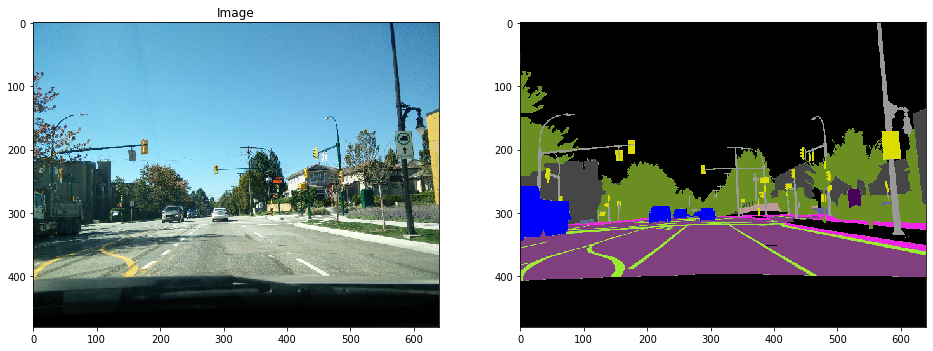

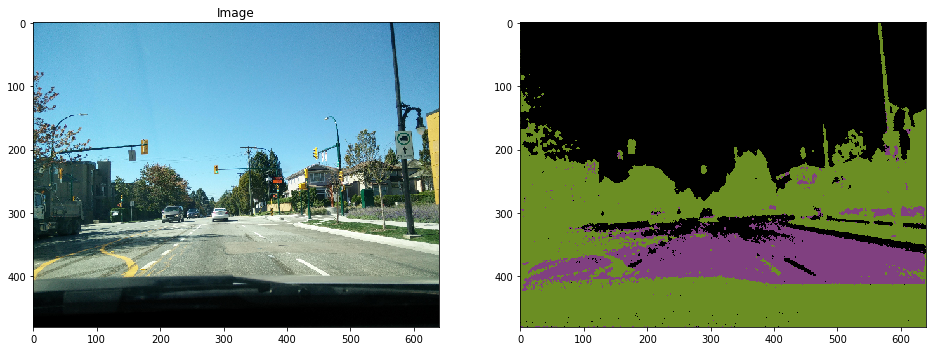

In [7]:
imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
model = load_model(f'seg_models/u-net_1585114900.h5')

img_predicted = model.predict(imges)[0]
target = maskes_to_labels(labels[0]).astype(np.uint8)


print(img_predicted.shape)

y_train_label = maskes_to_labels(img_predicted).astype(np.uint8)
compare_img(imges[0], target, 'Image', 'CityScape labels')
compare_img(imges[0], y_train_label, 'Image', 'CityScape labels')




In [8]:
pixel_score(y=labels[0], y_hat=img_predicted)


0.6205013020833333

In [9]:


#calculate old score with new
def calculate_score(rounds, score, old_score):
    return old_score * ((rounds-1)/rounds) + score *(1/rounds)


#output: score of model, mean and std
def try_model(key, imgs, labels, model_info, round_nr, lower_bound=True):
    old_score = model_info[key]['score']
    model_info[key]['round'] += 1
    rounds = model_info[key]['round']
    
    model = load_model(f'seg_models/{key}.h5')
    y_hat, mean, std = predictions_and_uncetrenty(model, 5, imgs)
    
    #make mean and std single values
    mean = mean.mean()
    std = std.mean()
    
    y_hat = y_hat.astype(np.float64)
    mean = mean.astype(np.float64)
    std = std.astype(np.float64)
    

    
    #print(y_hat.shape)
    score_p = pixel_score(labels[0], y_hat)
    score_iou = iou_score(labels[0], y_hat)
    
    #change from only using mean to lover bound of derivation
    if lower_bound:
        mean_score = calculate_score(rounds, mean - std, old_score)
    else: 
        mean_score = calculate_score(rounds, mean, old_score)
    
    model_info[key]['score'] = mean_score
    model_info[key]['used_index'].append(round_nr)
    model_info[key]['mean'] = mean
    model_info[key]['avg_mean'] = calculate_score(rounds, mean, model_info[key]['avg_mean'])
    model_info[key]['std'] = std
    model_info[key]['avg_std'] = calculate_score(rounds, std, model_info[key]['avg_std'])
   
    return score_p, score_iou, mean, std


## Policy gradient model


## Run policy gradinet



In [10]:
policy_lr = 1e-3 
value_lr = 1e-4 #-2

policy_clip = 3
value_clip = 3

reward_exponential = 10
reward_multi = 10

#tar in state og retunere action
class policy_model:
    #input (state, state, state, state, action)
    def __init__(self, innput_size, policy_lr, policy_clip=5):
        ACTI = 'relu'
        policy_lr = policy_lr
        policy_clip = policy_clip
        
        inputes = Input(shape=(innput_size*4,))
        actions_true = Input(shape=[innput_size], name='actions_true')
        advantages = Input(shape=[1], name='advantages')
        _ = Dense(512, activation=ACTI)(inputes) #512
        #_ = Dense(32, activation=ACTI)(_)
        #_ = Dropout(0.1)(_)
        #_ = Dense(256, activation=ACTI)(_)
        #_ = Dropout(0.1)(_)
        #_ = Dense(128, activation=ACTI)(_)
        out_1 = Dense(innput_size, activation='softmax')(_)

        
        #@tf.function
        def custom_loss_old(y_true, y_pred, adv):
            log_lik =  K.log(y_true * (y_true- y_pred) + (1 - y_true) * (y_true + y_pred))
            #loss = 1 / (-K.mean(log_lik * adv, keepdims=True))
            return K.mean(log_lik * adv, keepdims=True)
        
        def custom_loss(y_true, y_pred, adv):
            log_lik =  K.log(y_true * (y_true- y_pred) + (1 - y_true) * (y_true + y_pred))
            loss = 1 / (-K.mean(log_lik * adv, keepdims=True))
            return K.clip(loss, -5, 5)
            #return loss

        #self.policy.compile(optimizer=Adam(lr=1e-2), loss=custom_loss)
        self.policy = Model(inputs=[inputes, actions_true, advantages], outputs=[out_1])
        self.policy.add_loss(custom_loss(actions_true, out_1, advantages))
        self.policy.compile(optimizer=Adam(lr=policy_lr)) # -3, -2 give NaN if value is -4, 8e-3
        #self.policy.compile(optimizer=Adam(lr=1e-2), loss='mean_squared_error')
        #self.policy.compile(optimizer=Adam(lr=1e-1), loss='mean_squared_error')
        self.prediction = Model(inputs=inputes, outputs=[out_1])

    #trro vi bruke monte carlo, kjor en heil episode foor trening
    def partial_fit(self, x):
        return self.policy.train_on_batch(x)

    def partial_fit_two(self, x, y, adv):
        adv = np.array(adv)
        return self.policy.train_on_batch([x], y, sample_weight=adv)

    def predict(self, x):
        #print(f'x shape: {x.shape}')
        return self.prediction.predict(x=x)[0] #Why only take firse of 8 output :P 

    
    
class value_model:

    def __init__(self, innput_size, value_lr, value_clip=5):
        ACTI = 'relu'
        value_lr = value_lr
        value_clip = value_clip
        
        inputes = Input(shape=(innput_size*4,)) #dtype=float64
        _ = Dense(256, activation=ACTI)(inputes)
        _ = Dense(256, activation=ACTI)(_)
        #_ = Dropout(0.1)(_)
        _ = Dense(128, activation=ACTI)(_)
        #_ = Dropout(0.1)(_)
        _ = Dense(64, activation=ACTI)(_)
        out_1 = Dense(1)(_)
        #sgd = SGD(lr=1e-3) #5
        adam = Adam(lr=value_lr, clipvalue=5) # -3 workes

        self.model = Model(inputs=[inputes], outputs=[out_1])
        self.model.compile(optimizer=adam, loss='mean_squared_error')
        #self.model.compile(optimizer=sgd, loss=custom_loss)

    def partial_fit(self, x, y):
        x = np.array(x)
        return self.model.train_on_batch(x, y)


    def predict(self, x):
        return self.model.predict(x)[0]
    
def play_one_episode():
    pass


# 
def play_one_episode(hist_key, data_generator, model_info, value_fuction, policy_model, gamma, episode, box_size, batch_size):
    
    observations = []
    rewards = []
    actions = []
    
    pixel_scores_l = []
    iou_scores = []
    mean_scores = []
    std_scores = []
    
    possible_actions = range(0, box_size)
    
    g_sum = 0
    total_reward = 0
    
    #model_swich_keys = random.sample(model_info.keys(), 1)
    picked_key = hist_key#model_swich_keys[0]
    picked_value = model_info[hist_key]
    #print(f'picked_key: {picked_key}')
    
    key_list = list(model_info.keys())
    len_key_list = len(key_list)
    #First pick models (policy)
    for i in range(batch_size):
        
         #get new data set 
        img, label = next(data_generator)
        
        model_states = [picked_value['mean'], picked_value['std'], picked_value['avg_mean'], picked_value['avg_std']]
        model_states_keys = [picked_key]
        

            
       
        #test_key = key_list[key_index]#random.sample(model_info.keys(), 1)[0]
        
        #print(f'test key: {test_key}')
        
        
        
        for box_index in range(box_size-1):
            
            key_index = 0
            round_nr = episode + i + box_index
      
            if len(key_list) <= round_nr:
                key_index = (round_nr) - len(key_list) * ((round_nr) // len(key_list))
            else:
                key_index = round_nr
            test_key = key_list[key_index]
            #print(f'test key: {test_key}')
            model_states.append(model_info[test_key]['mean'])
            model_states.append(model_info[test_key]['std'])
            model_states.append(model_info[test_key]['avg_mean'])
            model_states.append(model_info[test_key]['avg_std'])
            
            model_states_keys.append(test_key)
                    
        
        #print(f'model state: {model_states.shape}')
        
        #print(f'Observation: {model_states}')
        action_prob = policy_model.predict(np.array([model_states]))
        #print(f'Action properbility: {action_prob}')
        #print(f'action prob: {action_prob}')
        picked_key = np.random.choice(model_states_keys, p=action_prob) #possible_actions

        #print(f'action keys: {action_key}')
        #picked_key = model_states_keys[action_key_index]
        picked_value = model_info[picked_key]
        
        action_hot_encoded = np.isin(model_states_keys, picked_key)
        #print(f'choosen action: {action_hot_encoded}')
        
        actions.append(action_hot_encoded)

    

    
        #second use picked model to to action and reward 
        score_pixel, score_iou,  mean, std = try_model(picked_key, img, label, model_info, episode)
        
        pixel_scores_l.append(score_pixel.astype(np.float64))
        iou_scores.append(score_iou.astype(np.float64))
        mean_scores.append(mean.astype(np.float64))
        std_scores.append(std.astype(np.float64))
        
        given_reward = 0
        #this need to change to mean, we wont have IoU in real scenario
        reward = mean - std
        '''
        
        if reward < 0.1:
            given_reward = 0
        elif reward < 0.15:
            given_reward = 1
        elif reward < 0.2:
            given_reward = 2
        elif reward < 0.25:
            given_reward = 4
        else:
            given_reward = 5

        '''
        given_reward += (reward**reward_exponential * reward_multi) # *10 
        
        #if picked_value['mean'] == picked_value['std'] == picked_value['avg_mean'] == picked_value['avg_std'] == 0:
        #   given_reward += 1
            
        rewards.append(given_reward)
        total_reward += given_reward
        observations.append(model_states)
    
    
    #print(model_states)
    #Thired train model :)
    actions = np.array(actions, dtype=np.int8)
    #print(f'Actions: {actions}')
    observations = np.array(observations)
    
    returns = []
    advateges = []
    
    for s, r in zip(reversed(observations), reversed(rewards)):
        returns.append(g_sum)
        adv = g_sum - value_fuction.predict(np.array([s]))
        advateges.append(adv)
        
        g_sum = r + g_sum * gamma
        
    returns.reverse()
    advateges.reverse()
    advateges = np.array(advateges)    
    
    
    
    
    obs = np.array(observations)

    
    value_loss = value_fuction.partial_fit(obs, returns)
    policy_loss = policy_model.partial_fit([obs, actions, advateges])
    #print(f'policy_loss: {policy_loss}')
    
    
    #policy_loss = policy_model.partial_fit_two(observations, action_hot_encoded, advateges)
    return picked_key, total_reward, policy_loss, value_loss, pixel_scores_l, iou_scores, mean_scores, std_scores
    
        
        
        
#value_func = value_model()
#policy_model = policy_model()

#imges, labels = next(batch_generator(img_val_list, color_label_val_list, color_id_map, [30], 1))
#print(play_one_episode(imges, labels, model_info, value_func, policy_model, 0.99, 1, 2, 1))


In [26]:
TEST_ROUNDS = 10
REDUCED_LIST = True
gamma = 1
box_size = 10 #2
value_func = value_model(box_size, policy_lr, policy_clip)
policy_mod = policy_model(box_size, value_lr, value_clip)

num_models = len(list(model_info.keys()))
index_list = range(1500, len(img_val_list))
num_trials = len(index_list) #// TEST_ROUNDS

In [ ]:





if REDUCED_LIST:
    key_list_remove = list(model_info.keys())[100:]
    for key in key_list_remove:
        del model_info[key]
        key_list_remove = list(model_info.keys())

gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)

policy_loss_list = []
value_loss_list = []
pixel_score_list = []
iou_score_list = []
mean_list = []
std_list = []
total_reward = []
key_list = list(model_info.keys())
hist_key = random.sample(key_list, 1)[0]

# run bandit thought validation
for i in range(0, len(index_list), TEST_ROUNDS):
    
    new_hist_key, reward, policy_loss, value_loss, pixel_s, iou_s, mean, std = play_one_episode(hist_key, gen, model_info, value_func, policy_mod, gamma, i ,box_size,TEST_ROUNDS)
    hist_key = new_hist_key 
    
    policy_loss_list.append(policy_loss[0][0].astype(np.float64))
    value_loss_list.append(value_loss.astype(np.float64))
    total_reward.append(reward)
    pixel_score_list += pixel_s
    iou_score_list += iou_s
    mean_list += mean
    std_list += std
    # Det OVER SKAL BYTTES
    
    

    K.clear_session()
    #scores.append(new_score)
    #iou_scores.append(score_iou)
    #score_counter.append(new_score)
    
    #means.append(mean)
    #epsilon *= gamma
    PRINT_STEP  = 10 // TEST_ROUNDS

    
    #if i % PRINT_STEP == 0 and i != 0:
    print()
    print('-------------------------- NEW ROUND -----------------------------')
    print(f'round: {i} of {len(index_list)}')
    print(f'policy loss: {policy_loss[0][0]}, value loss: {value_loss}, reward: {reward}')
    print(f'IoU score: {np.array(iou_s).mean()}, pixel_score: {np.array(pixel_s).mean()}, Mean: {np.array(mean).mean()}, Std: {np.array(std).mean()}')
    print()
    score_counter = []
        
        


In [15]:

#Reduce the list so graph get more general and easyer to read
def generalize_list(scores, batch_size):
    score_batch = []
    score_reduced = []
    x_akses = []
    for i in range(len(scores)):
        if i % batch_size == 0 and i != 0:
            score_reduced.append(sum(score_batch)/batch_size)
            score_batch = []
            x_akses.append(i)
        score_batch.append(scores[i])
    return score_reduced, x_akses

def score_graph(scores, iou_scores, means, model_info, batch_size, list_length):
    plt.figure(figsize=(16, 10))
    score_reduced = []


    model_score_avg = 0
    for key, value in model_info.items():
        model_score_avg += value['score']
    model_score_avg = model_score_avg / num_models


    # x_akses is the same in both instances
    iou_scores_reduced, _ = generalize_list(iou_scores, batch_size)
    score_reduced, x_akses = generalize_list(scores, batch_size)
    mean_reduced, _ = generalize_list(means, batch_size)
    
    
    print(f' Avg score pr model: {model_score_avg}')
    
    avg = np.array([model_score_avg for i in range(list_length)])
    avg_explore = np.array([0.519 for i in range(list_length)]) # 0.5186551321699284
    #avg_iou = np.array([0.0185 for i in range(list_length)]) #0.0185 0.13364625770486935
    avg_iou = np.array([0.101 for i in range(list_length)]) #0.10119017522614594
    
    #plt.bar(, y_akses_list)
    plt.ylim(0,1)
    plt.xlabel('time', fontsize=20)
    plt.ylabel('Percentage right', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)

    plt.plot(avg, 'r--', label='Average Lower Bound')
    plt.plot(avg_explore, 'm--', label='Average score')
    plt.plot(avg_iou, 'y--', label='Average IoU')
    plt.plot(x_akses, mean_reduced,'g' ,linewidth=3, label='Mean')
    plt.plot(x_akses, score_reduced,'b' ,linewidth=3, label='pixel score')
    plt.plot(x_akses, iou_scores_reduced,'c' ,linewidth=3, label='iou score')
    plt.legend(loc='best', fontsize=15)
    plt.show()



In [16]:
score_graph(pixel_score_list, iou_score_list, mean_list, model_info, batch_size=10, list_length=num_trials*TEST_ROUNDS)

NameError: name 'pixel_score_list' is not defined

In [ ]:



for key, value in model_info.items():
    print(f'Key: {key}, score: {value["score"]}, mean: {value["mean"]}, std: {value["std"]}, avg mean: {value["avg_mean"]}, avg std: {value["avg_std"]}, rounds: {value["round"]}, time used: {value["used_index"]}')
    print()

In [17]:
def plot_model_used(model_info, num_models, num_trials, batch_size):
    model_used = np.zeros((num_models, num_trials), dtype=np.uint8)

    #smooth = (len(index_list)+batch_size)//batch_size
    #print(smooth)

    counter = 0
    for key, value in model_info.items():
        #model_used[counter]
        for index in value['used_index']:
            model_used[counter][index] = 1

        counter += 1 

    model_used_smoothe = [] #np.zeros((len(key_list), smooth), dtype=np.uint8)
    counter = 0
    for used in model_used:
        periodic = []
        model_used_smoothe.append([])
        for i in range(len(used)):
            if i % batch_size == 0 and i != 0:
                model_used_smoothe[counter].append(sum(periodic))
                periodic = []
            periodic.append(used[i])
        counter += 1


    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)

    for used_per in model_used_smoothe:
        #print(used_per)
        plt.plot(used_per)
    #print(model_used_smoothe[5])
    #plt.plot(model_used_smoothe[5])
    plt.show()


In [ ]:
plot_model_used(model_info, num_models, len(index_list), batch_size=10)

In [18]:

def scatter_model_used(model_info, num_models, num_trials):
    counter = 0
    used_list = []
    
    for _ in range(num_models):
        used_list.append(np.full(num_trials, -10))
    
    for key, value in model_info.items():

        for used in value['used_index']:
            used_list[counter][used] = counter

        counter += 1
        
    counter_list = range(num_trials)
    
    plt.figure(figsize=(16, 10))
    plt.tick_params(axis='both', which='major', labelsize=15)
    plt.ylim(0, int(round(num_models * 1.05)))
    for i in range(num_models):
        plt.scatter(counter_list, used_list[i])
    plt.show()


#scatter_model_used(model_info, num_models, num_trials)

In [ ]:
scatter_model_used(model_info, num_models, len(index_list))

In [19]:
def plot_loss(policy_list, title):
    plt.figure(figsize=(16, 10))
    #plt.ylim(0,1)
    plt.xlabel('Step', fontsize=20)
    plt.ylabel('Loss', fontsize=20)
    #plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(title, fontsize=30)

    plt.plot(policy_list,'m' ,linewidth=3, label='Loss')
    plt.legend(loc='best', fontsize=15)
    plt.show()




In [ ]:
policy_loss = np.array(policy_loss_list).ravel()
plot_loss(policy_loss, 'Policy Loss')
print(type(pixel_score_list))
print(type(pixel_score_list[0]))

In [ ]:
value_loss = np.array(value_loss_list).ravel()
plot_loss(value_loss, 'Value Loss')
print(type(std_list))
print(type(std_list[0]))

In [ ]:
print('Average ressults') #0.3, 0.2
print(f'Score: {np.array(pixel_score_list).mean()}') #0.6452791124131944, #0.6169490690104167
print(f'Mean: {np.array(mean_list).mean()}') # 0.6408893465995789, #0.6559882760047913
print(f'IoU Score: {np.array(iou_score_list).mean()}') #0.01849434094551282, 0.103, # found around 450


In [ ]:
optimizer = 'Adam'
model_info_save = {
    'policy_lr': policy_lr,
    'value_lr': value_lr,
    'policy_clip': policy_clip,
    'value_clip': value_clip,
    'reward_exponential': reward_exponential,
    'reward_multi': reward_multi,
    'batch_size': TEST_ROUNDS,
    'box_size': box_size,
    'gamma': gamma,
    'reward_list': total_reward,
    'policy_loss': policy_loss_list,
    'value_loss': value_loss_list,
    'optimizer': optimizer,
    'num_models': num_models,
    'num_trials': len(index_list),
    'iou_scores': iou_score_list,
    'pixel_scores': pixel_score_list,
    'mean_values': mean_list,
    'std_values': std_list,
    'model_info': model_info 
}
#model_info, num_models, num_trials
file_save_path_name = f'pg_ressults/policy_gradient_{optimizer}_{policy_lr}_{np.array(total_reward).mean()}.json'

with open(file_save_path_name, "w") as file_write:
    # write json data into file
    json.dump(model_info_save, file_write)
file_write.close() 

## UCB1

Average ressults UCB 1:
Score: 0.72
Mean: 0.73
Iou: 0.25

In [12]:
gen = batch_generator(img_val_list, color_label_val_list, color_id_map, index_list, 1)
models_gen = model_generator(model_info_ubc1, 50, 2)

scores_ucb1 = []
iou_scores_ucb1 = []
means_ucb1 = []
score_counter_ucb1 = []



def ucb1_score(rounds, model_info, c):
    model_round = model_info['round']
    
    if model_round == 0:
        return np.inf
    #print(f'rounds: {model_info["round"]} ,score: {model_info["score"]} time used: {model_info["used_index"]}')
    explotation = model_info['score']
    explortion = math.sqrt(math.log(rounds)/model_round)
    
    return explotation + c*explortion


# run bandit thought validation
for i in range(len(index_list)):
    
    #print(f'round: {i} of {len(index_list)}')
    imgs, labels = next(gen)
    models_UCB1_in_use = next(models_gen)
        
    best_model_key = None
    best_score = -np.inf
    printe_score = True
    num_models = len(models_UCB1_in_use.keys())
    
    for key, value in models_UCB1_in_use.items():
        score = ucb1_score(rounds=i, model_info=value, c=0.05) 
        #save some init time
        if score == np.inf:
            if i > num_models:
                print('FAAAAIL')
            best_model_key = key
            break
            
        if printe_score:
            printe_score = False
        
        if score > best_score:
            best_score = score
            best_model_key = key
            
    
    new_score, score_iou, mean, std = try_model(best_model_key, imgs, labels, models_UCB1_in_use, i)

    
    #print(f'mean: {mean}, std: {std}')
    

    K.clear_session()
    scores_ucb1.append(new_score)
    score_counter_ucb1.append(new_score)
    means_ucb1.append(mean)
    iou_scores_ucb1.append(score_iou)
    #epsilon *= gamma
    
    if i % 10 == 0:
        printe_score = True
        print(f'round: {i} of {len(index_list)}, score: {sum(score_counter_ucb1)}')
        score_counter_ucb1 = []
        


round: 0 of 500, score: 0.559140625
round: 10 of 500, score: 4.0067773437500005
round: 20 of 500, score: 4.930852864583333
round: 30 of 500, score: 5.343326822916667
round: 40 of 500, score: 5.91666015625
round: 50 of 500, score: 6.565260416666666
round: 60 of 500, score: 5.065009765625
round: 70 of 500, score: 4.666106770833333
round: 80 of 500, score: 3.750205078125
round: 90 of 500, score: 5.639140624999999
round: 100 of 500, score: 5.146022135416667
round: 110 of 500, score: 5.512529296875
round: 120 of 500, score: 4.006904296875
round: 130 of 500, score: 4.077932942708333
round: 140 of 500, score: 4.84916015625
round: 150 of 500, score: 5.57017578125
round: 160 of 500, score: 4.826165364583333
round: 170 of 500, score: 6.7808626302083335
round: 180 of 500, score: 6.467014973958333
round: 190 of 500, score: 6.245432942708333
round: 200 of 500, score: 6.4024479166666675
round: 210 of 500, score: 5.858030598958333
round: 220 of 500, score: 3.2117154947916666
round: 230 of 500, score:

 Avg score pr model: 0.4452057154118605


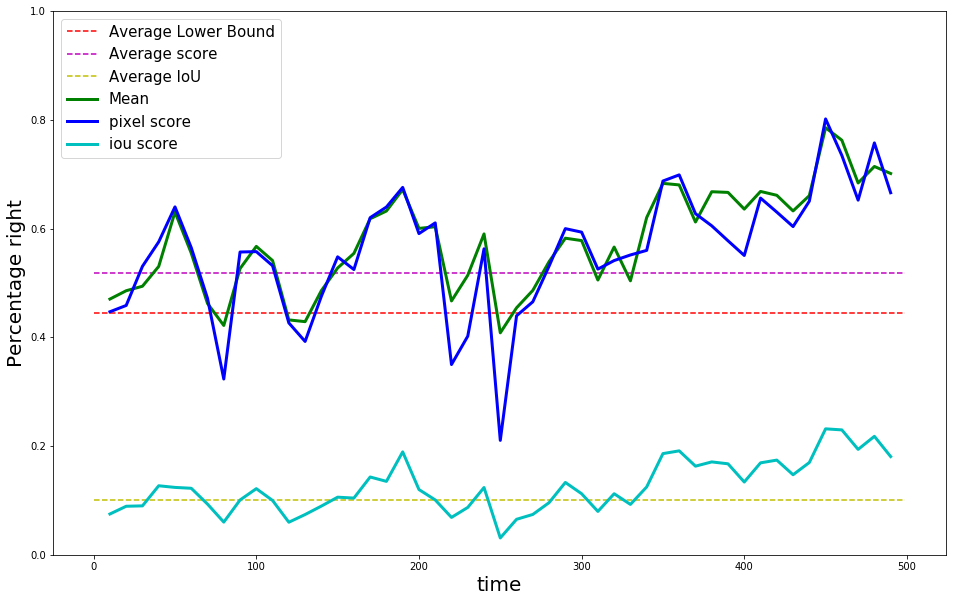

In [27]:
score_graph(scores_ucb1, iou_scores_ucb1, means_ucb1, model_info_ubc1, batch_size=10, list_length=num_trials)

In [28]:
for key, value in models_UCB1_in_use.items():
    print(f'Key: {key}, rounds: {value["round"]} ,score: {value["score"]} time used: {value["used_index"]}')
    print()

Key: u-net_1585114900, rounds: 1 ,score: 0.5064430795609951 time used: [0]

Key: u-net_1585115750, rounds: 1 ,score: 0.329019123892067 time used: [1]

Key: u-net_1585116680, rounds: 1 ,score: 0.3838348910212517 time used: [2]

Key: u-net_1585118770, rounds: 1 ,score: 0.5171844363212585 time used: [3]

Key: u-net_1585123137, rounds: 1 ,score: 0.2790824417024851 time used: [4]

Key: u-net_1585126633, rounds: 3 ,score: 0.6285504475235939 time used: [5, 356, 415]

Key: u-net_1585130481, rounds: 1 ,score: 0.32731150672771037 time used: [6]

Key: u-net_1585133766, rounds: 1 ,score: 0.5461651124060154 time used: [7]

Key: u-net_1585136637, rounds: 1 ,score: 0.33588085509836674 time used: [8]

Key: u-net_1585145765, rounds: 1 ,score: 0.3556022457778454 time used: [9]

Key: u-net_1585155175, rounds: 1 ,score: 0.3119751811027527 time used: [10]

Key: u-net_1585164469, rounds: 1 ,score: 0.510867565870285 time used: [11]

Key: u-net_1585201143, rounds: 1 ,score: 0.18808966502547264 time used: [12]

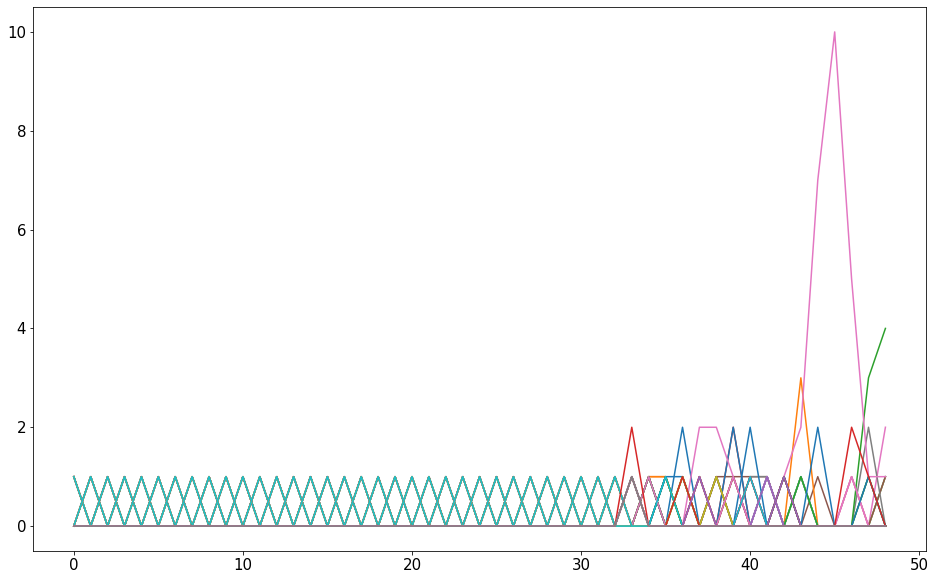

In [29]:
num_models = len(models_UCB1_in_use.keys())

plot_model_used(models_UCB1_in_use, num_models, num_trials, batch_size=10)

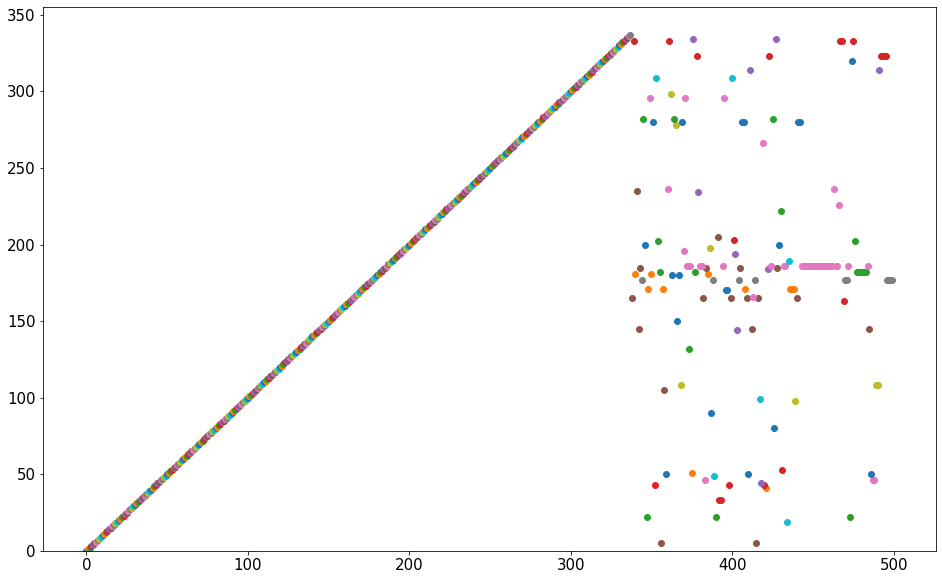

In [30]:
scatter_model_used(models_UCB1_in_use, num_models, num_trials)

In [ ]:
print('Average ressults')
print(f'Score: {np.array(scores_ucb1).mean()}')
print(f'Mean: {np.array(means_ucb1).mean()}')
print(f'IoU score: {np.array(iou_scores_ucb1).mean()}')

Average ressults UCB 1:
Score: 0.72
Mean: 0.73
Iou: 0.25